In [ ]:
!pip install medmnist -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import medmnist
from medmnist import INFO
from tqdm import tqdm
import cv2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 5.9 MB/s eta 0:00:00


In [ ]:
# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")
if device.type == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

✅ Using device: cuda
   GPU: Tesla T4


In [ ]:
print("\n📦 Loading PneumoniaMNIST Dataset...")

data_flag = 'pneumoniamnist'
info = INFO[data_flag]
n_classes = len(info['label'])

print(f"   Dataset: {info['description']}")
print(f"   Task: {info['task']}")
print(f"   Number of classes: {n_classes}")


📦 Loading PneumoniaMNIST Dataset...
   Dataset: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
   Task: binary-class
   Number of classes: 2


In [ ]:
# Data augmentation for training
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [ ]:
# No augmentation for validation/test
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [ ]:
DataClass = getattr(medmnist, info['python_class'])
train_dataset = DataClass(split='train', transform=train_transform, download=True)
val_dataset = DataClass(split='val', transform=test_transform, download=True)
test_dataset = DataClass(split='test', transform=test_transform, download=True)

print(f"   Train size: {len(train_dataset)}")
print(f"   Validation size: {len(val_dataset)}")
print(f"   Test size: {len(test_dataset)}")

100%|██████████| 4.17M/4.17M [00:07<00:00, 586kB/s]


   Train size: 4708
   Validation size: 524
   Test size: 624


In [ ]:
batch_size = 128  # Larger batch size for GPU
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


📊 Analyzing Dataset Composition...

DATASET COMPOSITION
Training Set:
   Normal:    1214 (25.8%)
   Pneumonia: 3494 (74.2%)
   Total:     4708

Validation Set:
   Normal:     135 (25.8%)
   Pneumonia:  389 (74.2%)
   Total:      524

Test Set:
   Normal:     234 (37.5%)
   Pneumonia:  390 (62.5%)
   Total:      624

📊 Overall Distribution:
   Total Normal:    1583
   Total Pneumonia: 4273
   Grand Total:     5856

⚖️ Class Imbalance Ratio: 2.88:1
   ⚠️ Dataset is imbalanced! Consider using weighted loss or oversampling.


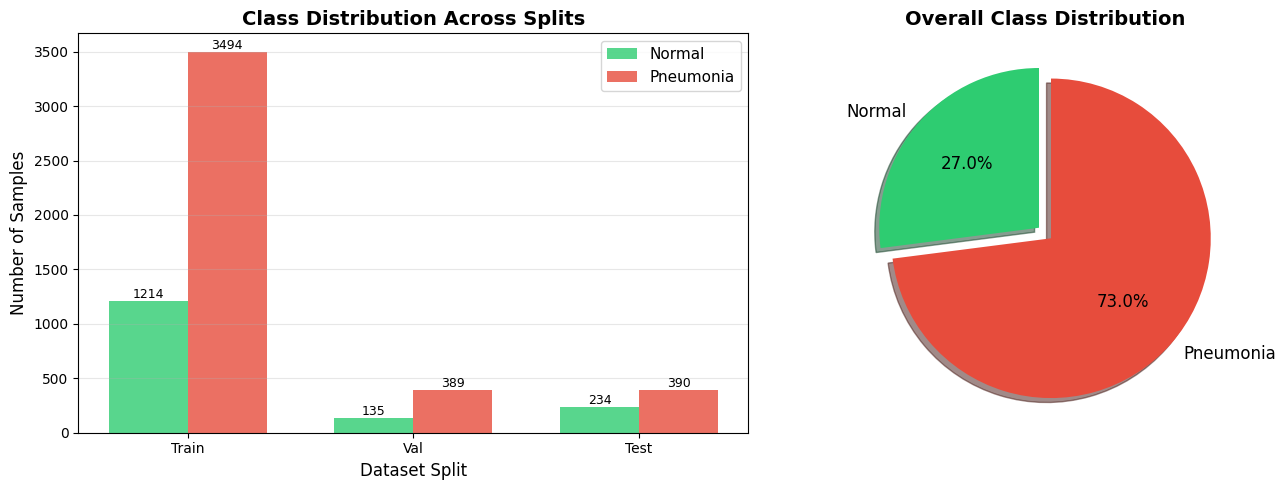

In [ ]:
print("\n📊 Analyzing Dataset Composition...")

# Count classes in each split
def count_classes(dataset):
    normal_count = 0
    pneumonia_count = 0
    for _, label in dataset:
        if label.item() == 0:
            normal_count += 1
        else:
            pneumonia_count += 1
    return normal_count, pneumonia_count

train_normal, train_pneumonia = count_classes(train_dataset)
val_normal, val_pneumonia = count_classes(val_dataset)
test_normal, test_pneumonia = count_classes(test_dataset)

print("\n" + "="*60)
print("DATASET COMPOSITION")
print("="*60)
print(f"Training Set:")
print(f"   Normal:    {train_normal:4d} ({train_normal/len(train_dataset)*100:.1f}%)")
print(f"   Pneumonia: {train_pneumonia:4d} ({train_pneumonia/len(train_dataset)*100:.1f}%)")
print(f"   Total:     {len(train_dataset):4d}")
print(f"\nValidation Set:")
print(f"   Normal:    {val_normal:4d} ({val_normal/len(val_dataset)*100:.1f}%)")
print(f"   Pneumonia: {val_pneumonia:4d} ({val_pneumonia/len(val_dataset)*100:.1f}%)")
print(f"   Total:     {len(val_dataset):4d}")
print(f"\nTest Set:")
print(f"   Normal:    {test_normal:4d} ({test_normal/len(test_dataset)*100:.1f}%)")
print(f"   Pneumonia: {test_pneumonia:4d} ({test_pneumonia/len(test_dataset)*100:.1f}%)")
print(f"   Total:     {len(test_dataset):4d}")
print(f"\n📊 Overall Distribution:")
print(f"   Total Normal:    {train_normal + val_normal + test_normal}")
print(f"   Total Pneumonia: {train_pneumonia + val_pneumonia + test_pneumonia}")
print(f"   Grand Total:     {len(train_dataset) + len(val_dataset) + len(test_dataset)}")
print("="*60)

# Class imbalance ratio
imbalance_ratio = max(train_pneumonia, train_normal) / min(train_pneumonia, train_normal)
print(f"\n⚖️ Class Imbalance Ratio: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 1.5:
    print(f"   ⚠️ Dataset is imbalanced! Consider using weighted loss or oversampling.")
else:
    print(f"   ✅ Dataset is relatively balanced.")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
splits = ['Train', 'Val', 'Test']
normal_counts = [train_normal, val_normal, test_normal]
pneumonia_counts = [train_pneumonia, val_pneumonia, test_pneumonia]

x = np.arange(len(splits))
width = 0.35

bars1 = axes[0].bar(x - width/2, normal_counts, width, label='Normal', color='#2ecc71', alpha=0.8)
bars2 = axes[0].bar(x + width/2, pneumonia_counts, width, label='Pneumonia', color='#e74c3c', alpha=0.8)

axes[0].set_xlabel('Dataset Split', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_title('Class Distribution Across Splits', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(splits)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontsize=9)

# Pie chart for overall distribution
total_normal = train_normal + val_normal + test_normal
total_pneumonia = train_pneumonia + val_pneumonia + test_pneumonia
sizes = [total_normal, total_pneumonia]
colors = ['#2ecc71', '#e74c3c']
explode = (0.05, 0.05)

axes[1].pie(sizes, explode=explode, labels=['Normal', 'Pneumonia'], colors=colors,
           autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 12})
axes[1].set_title('Overall Class Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('dataset_composition.png', dpi=300, bbox_inches='tight')
plt.show()


🖼️ Visualizing Sample Images (High Quality)...


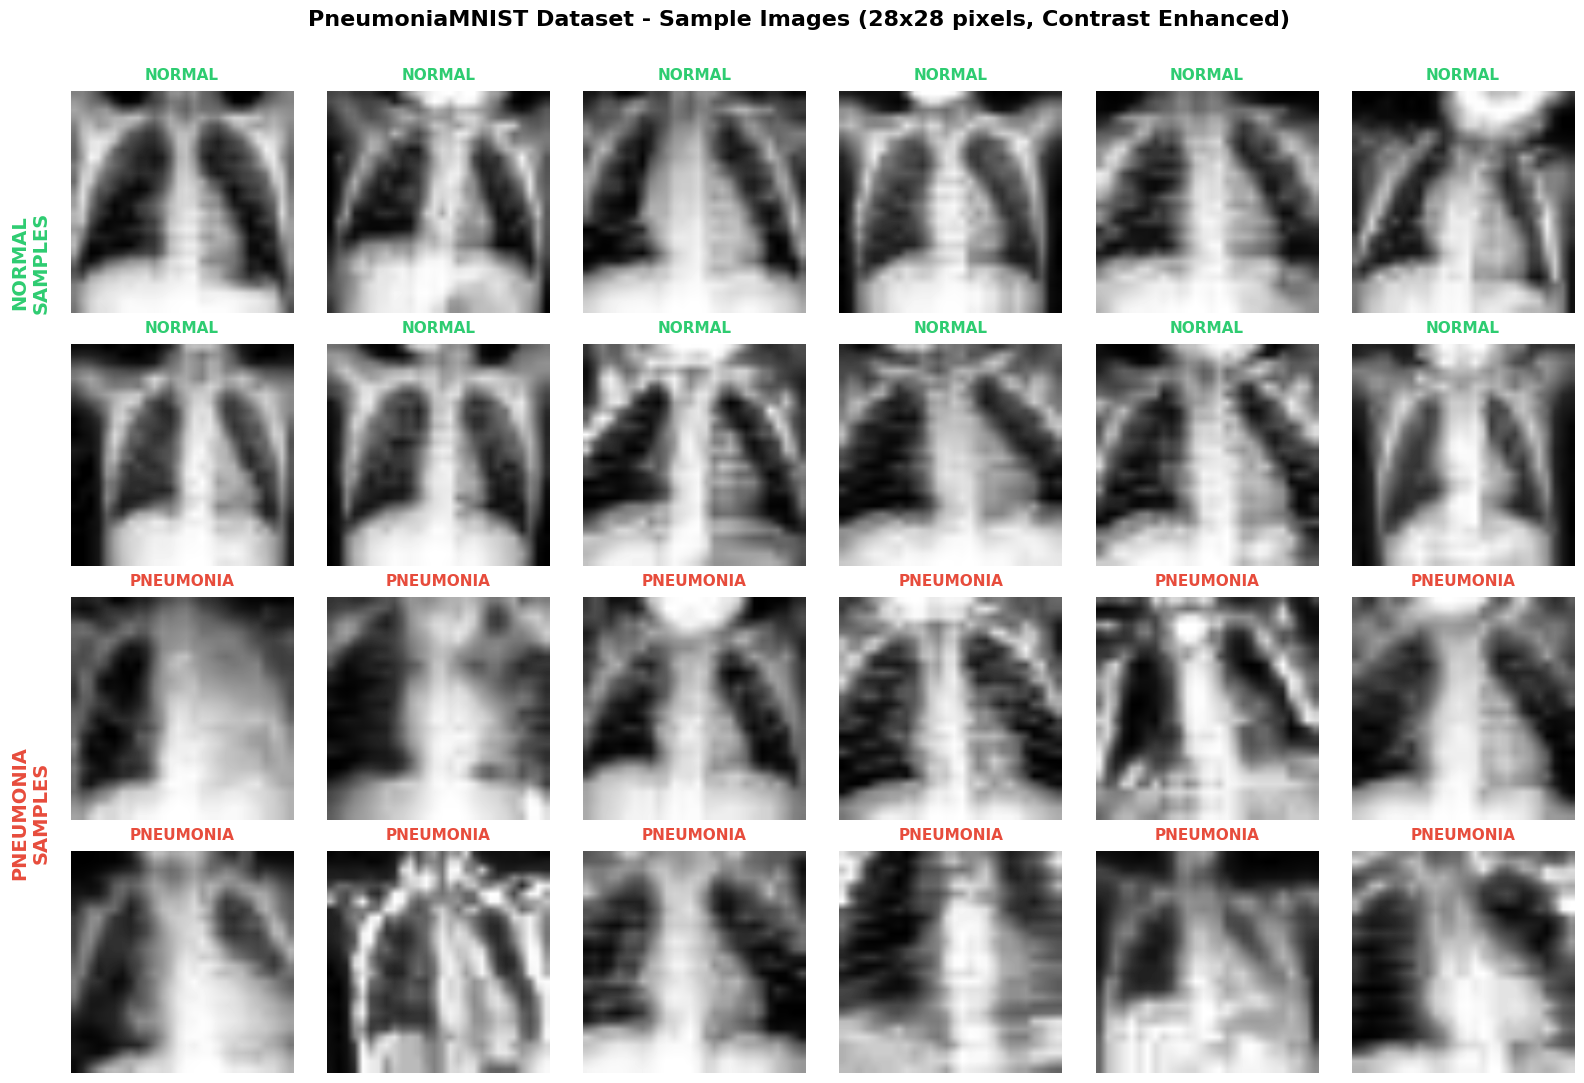

In [ ]:
print("\n🖼️ Visualizing Sample Images (High Quality)...")

# Create dataset without normalization for better visualization
viz_transform = transforms.Compose([transforms.ToTensor()])
DataClass = getattr(medmnist, info['python_class'])
viz_dataset = DataClass(split='train', transform=viz_transform, download=False)

fig, axes = plt.subplots(4, 6, figsize=(16, 11))

# Get balanced samples (3 rows each class)
normal_samples = [i for i, (_, label) in enumerate(viz_dataset) if label.item() == 0]
pneumonia_samples = [i for i, (_, label) in enumerate(viz_dataset) if label.item() == 1]

selected_normal = np.random.choice(normal_samples, 12, replace=False)
selected_pneumonia = np.random.choice(pneumonia_samples, 12, replace=False)

for idx in range(24):
    row = idx // 6
    col = idx % 6

    if idx < 12:
        # Normal samples (first 2 rows)
        sample_idx = selected_normal[idx]
        label_text = "NORMAL"
        color = '#2ecc71'
    else:
        # Pneumonia samples (last 2 rows)
        sample_idx = selected_pneumonia[idx - 12]
        label_text = "PNEUMONIA"
        color = '#e74c3c'

    img, label = viz_dataset[sample_idx]
    img_display = img.squeeze().numpy()

    # Apply histogram equalization for better contrast
    img_display = (img_display * 255).astype(np.uint8)
    img_display = cv2.equalizeHist(img_display)

    axes[row, col].imshow(img_display, cmap='gray', interpolation='bilinear')
    axes[row, col].set_title(label_text, fontsize=11, fontweight='bold',
                            color=color, pad=8)
    axes[row, col].axis('off')

    # Add border
    for spine in axes[row, col].spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(2)

# Add row labels
fig.text(0.02, 0.75, 'NORMAL\nSAMPLES', fontsize=14, fontweight='bold',
         color='#2ecc71', ha='center', va='center', rotation=90)
fig.text(0.02, 0.25, 'PNEUMONIA\nSAMPLES', fontsize=14, fontweight='bold',
         color='#e74c3c', ha='center', va='center', rotation=90)

plt.suptitle('PneumoniaMNIST Dataset - Sample Images (28x28 pixels, Contrast Enhanced)',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0.03, 0, 1, 0.97])
plt.savefig('dataset_samples_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print("\n🏗️ Building CNN Model...")

class PneumoniaCNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=1):
        super(PneumoniaCNN, self).__init__()

        self.features = nn.Sequential(
            # Block 1: 28x28 -> 14x14
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            # Block 2: 14x14 -> 7x7
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            # Block 3: 7x7 -> 3x3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


🏗️ Building CNN Model...


In [ ]:
# Initialize model
model = PneumoniaCNN(in_channels=1, num_classes=1).to(device)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")

   Total parameters: 615,521
   Trainable parameters: 615,521


In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=25, lr=0.001):
    device = next(model.parameters()).device

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_auc': [], 'val_auc': []
    }

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # ================= TRAIN =================
        model.train()
        train_loss = 0.0
        train_preds, train_labels, train_probs = [], [], []

        for images, labels in tqdm(train_loader, desc="Training"):
            images = images.to(device)
            labels = labels.float().to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()


            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
            train_probs.extend(probs.detach().cpu().numpy())

        train_loss /= len(train_loader.dataset)
        train_acc = accuracy_score(train_labels, train_preds)

        train_labels_np = np.array(train_labels).ravel()
        train_probs_np = np.array(train_probs).ravel()

        train_auc = (
            roc_auc_score(train_labels_np, train_probs_np)
            if len(np.unique(train_labels_np)) > 1 else 0.5
        )

        # ================= VALIDATION =================
        model.eval()
        val_loss = 0.0
        val_preds, val_labels, val_probs = [], [], []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images = images.to(device)
                labels = labels.float().to(device).view(-1, 1)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()


                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_probs.extend(probs.detach().cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = accuracy_score(val_labels, val_preds)

        val_labels_np = np.array(val_labels).ravel()
        val_probs_np = np.array(val_probs).ravel()

        val_auc = (
            roc_auc_score(val_labels_np, val_probs_np)
            if len(np.unique(val_labels_np)) > 1 else 0.5
        )

        scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_auc'].append(train_auc)
        history['val_auc'].append(val_auc)

        print(
            f"Train → Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, AUC: {train_auc:.4f}\n"
            f"Val   → Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, AUC: {val_auc:.4f}\n"
            f"LR: {optimizer.param_groups[0]['lr']:.6f}"
        )

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_pneumonia_cnn.pth")
            print(f"✅ Best model saved (Val Acc = {best_val_acc:.4f})")

    return history


In [ ]:
print("\n🚀 Starting training...\n")

history = train_model(model, train_loader, val_loader, num_epochs=25, lr=0.001)


🚀 Starting training...


Epoch 1/25


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.02it/s]


Train → Loss: 0.2792, Acc: 0.8738, AUC: 0.9376
Val   → Loss: 0.5518, Acc: 0.8263, AUC: 0.9747
LR: 0.001000
✅ Best model saved (Val Acc = 0.8263)

Epoch 2/25


Validation: 100%|██████████| 5/5 [00:00<00:00, 26.43it/s]


Train → Loss: 0.1535, Acc: 0.9433, AUC: 0.9807
Val   → Loss: 0.1852, Acc: 0.9218, AUC: 0.9871
LR: 0.001000
✅ Best model saved (Val Acc = 0.9218)

Epoch 3/25


Validation: 100%|██████████| 5/5 [00:00<00:00, 23.07it/s]


Train → Loss: 0.1406, Acc: 0.9463, AUC: 0.9838
Val   → Loss: 0.2337, Acc: 0.8989, AUC: 0.9875
LR: 0.001000

Epoch 4/25


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.32it/s]


Train → Loss: 0.1247, Acc: 0.9537, AUC: 0.9873
Val   → Loss: 0.1975, Acc: 0.9198, AUC: 0.9926
LR: 0.001000

Epoch 5/25


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.69it/s]


Train → Loss: 0.1216, Acc: 0.9562, AUC: 0.9878
Val   → Loss: 0.1155, Acc: 0.9599, AUC: 0.9899
LR: 0.001000
✅ Best model saved (Val Acc = 0.9599)

Epoch 6/25


Validation: 100%|██████████| 5/5 [00:00<00:00, 26.13it/s]


Train → Loss: 0.1153, Acc: 0.9554, AUC: 0.9892
Val   → Loss: 0.1149, Acc: 0.9599, AUC: 0.9899
LR: 0.001000

Epoch 7/25


Validation: 100%|██████████| 5/5 [00:00<00:00, 26.54it/s]


Train → Loss: 0.1011, Acc: 0.9609, AUC: 0.9919
Val   → Loss: 0.1113, Acc: 0.9580, AUC: 0.9922
LR: 0.001000

Epoch 8/25


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.85it/s]


Train → Loss: 0.1240, Acc: 0.9560, AUC: 0.9873
Val   → Loss: 0.1121, Acc: 0.9523, AUC: 0.9903
LR: 0.001000

Epoch 9/25


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.98it/s]


Train → Loss: 0.1066, Acc: 0.9599, AUC: 0.9909
Val   → Loss: 0.1260, Acc: 0.9485, AUC: 0.9936
LR: 0.001000

Epoch 10/25


Validation: 100%|██████████| 5/5 [00:00<00:00, 26.98it/s]


Train → Loss: 0.0964, Acc: 0.9630, AUC: 0.9923
Val   → Loss: 0.0823, Acc: 0.9695, AUC: 0.9954
LR: 0.001000
✅ Best model saved (Val Acc = 0.9695)

Epoch 11/25


Validation: 100%|██████████| 5/5 [00:00<00:00, 28.41it/s]


Train → Loss: 0.0914, Acc: 0.9643, AUC: 0.9932
Val   → Loss: 0.0756, Acc: 0.9733, AUC: 0.9960
LR: 0.001000
✅ Best model saved (Val Acc = 0.9733)

Epoch 12/25


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.04it/s]


Train → Loss: 0.0848, Acc: 0.9694, AUC: 0.9939
Val   → Loss: 0.0754, Acc: 0.9714, AUC: 0.9958
LR: 0.001000

Epoch 13/25


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.68it/s]


Train → Loss: 0.0897, Acc: 0.9652, AUC: 0.9935
Val   → Loss: 0.0751, Acc: 0.9714, AUC: 0.9958
LR: 0.001000

Epoch 14/25


Validation: 100%|██████████| 5/5 [00:00<00:00, 26.77it/s]


Train → Loss: 0.0883, Acc: 0.9658, AUC: 0.9936
Val   → Loss: 0.1010, Acc: 0.9656, AUC: 0.9957
LR: 0.001000

Epoch 15/25


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.80it/s]


Train → Loss: 0.0850, Acc: 0.9690, AUC: 0.9937
Val   → Loss: 0.1261, Acc: 0.9618, AUC: 0.9951
LR: 0.001000

Epoch 16/25


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.42it/s]


Train → Loss: 0.0842, Acc: 0.9692, AUC: 0.9941
Val   → Loss: 0.0687, Acc: 0.9733, AUC: 0.9963
LR: 0.001000

Epoch 17/25


Validation: 100%|██████████| 5/5 [00:00<00:00, 28.15it/s]


Train → Loss: 0.0806, Acc: 0.9690, AUC: 0.9946
Val   → Loss: 0.0666, Acc: 0.9714, AUC: 0.9968
LR: 0.001000

Epoch 18/25


Validation: 100%|██████████| 5/5 [00:00<00:00, 25.15it/s]


Train → Loss: 0.0790, Acc: 0.9681, AUC: 0.9950
Val   → Loss: 0.0890, Acc: 0.9733, AUC: 0.9946
LR: 0.001000

Epoch 19/25


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.26it/s]


Train → Loss: 0.0798, Acc: 0.9705, AUC: 0.9948
Val   → Loss: 0.0914, Acc: 0.9714, AUC: 0.9940
LR: 0.001000

Epoch 20/25


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.63it/s]


Train → Loss: 0.0761, Acc: 0.9703, AUC: 0.9952
Val   → Loss: 0.0863, Acc: 0.9714, AUC: 0.9957
LR: 0.001000

Epoch 21/25


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.69it/s]


Train → Loss: 0.0744, Acc: 0.9728, AUC: 0.9954
Val   → Loss: 0.0796, Acc: 0.9656, AUC: 0.9966
LR: 0.000500

Epoch 22/25


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.58it/s]


Train → Loss: 0.0677, Acc: 0.9758, AUC: 0.9962
Val   → Loss: 0.0584, Acc: 0.9790, AUC: 0.9970
LR: 0.000500
✅ Best model saved (Val Acc = 0.9790)

Epoch 23/25


Validation: 100%|██████████| 5/5 [00:00<00:00, 21.12it/s]


Train → Loss: 0.0638, Acc: 0.9800, AUC: 0.9960
Val   → Loss: 0.0829, Acc: 0.9714, AUC: 0.9961
LR: 0.000500

Epoch 24/25


Validation: 100%|██████████| 5/5 [00:00<00:00, 27.91it/s]


Train → Loss: 0.0672, Acc: 0.9739, AUC: 0.9964
Val   → Loss: 0.0747, Acc: 0.9733, AUC: 0.9960
LR: 0.000500

Epoch 25/25


Validation: 100%|██████████| 5/5 [00:00<00:00, 28.17it/s]


Train → Loss: 0.0610, Acc: 0.9790, AUC: 0.9968
Val   → Loss: 0.0884, Acc: 0.9714, AUC: 0.9961
LR: 0.000500



📊 Plotting training history...


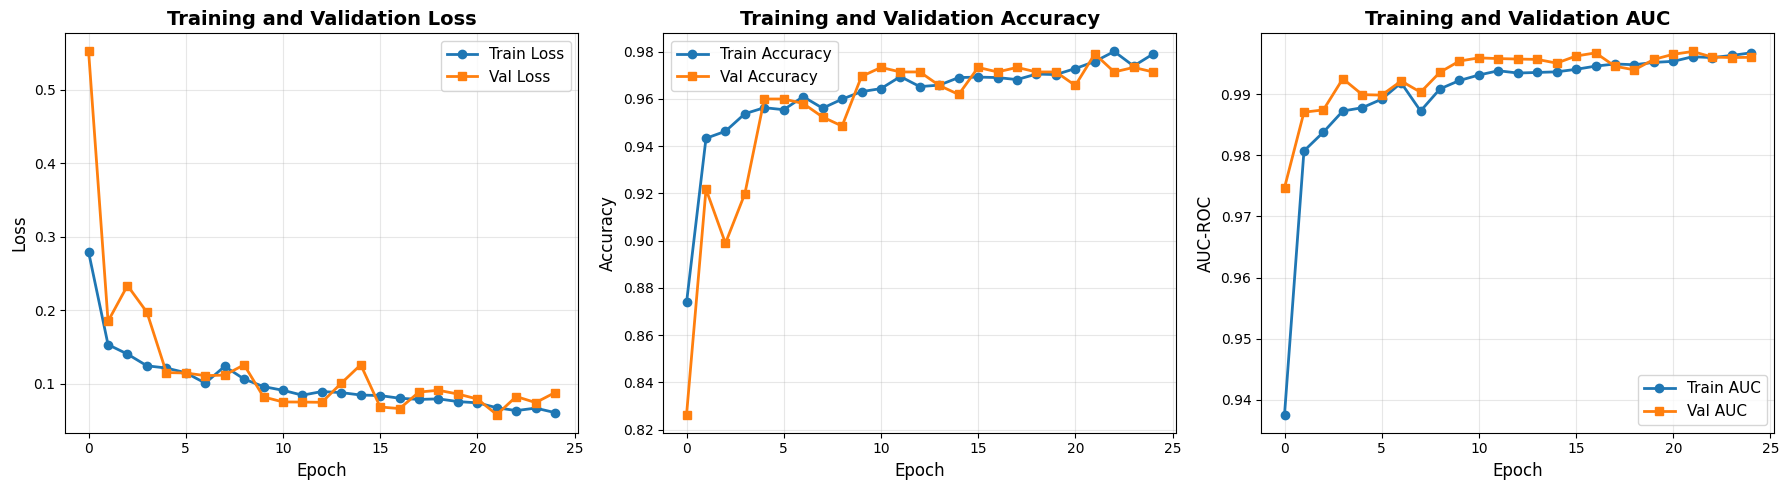

In [ ]:
  # ============================================================================
# 6. PLOT TRAINING HISTORY
# ============================================================================
print("\n📊 Plotting training history...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Accuracy', marker='s', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# AUC plot
axes[2].plot(history['train_auc'], label='Train AUC', marker='o', linewidth=2)
axes[2].plot(history['val_auc'], label='Val AUC', marker='s', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('AUC-ROC', fontsize=12)
axes[2].set_title('Training and Validation AUC', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================================================
# 7. EVALUATE ON TEST SET
# ============================================================================
print("\n🧪 Evaluating on test set...")

# Load best model
model.load_state_dict(torch.load('best_pneumonia_cnn.pth'))
model.eval()

all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        labels = labels.float().to(device)

        outputs = model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)
cm = confusion_matrix(all_labels, all_preds)

print("\n" + "="*60)
print("📈 TEST SET RESULTS")
print("="*60)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")
print("="*60)


🧪 Evaluating on test set...


Testing: 100%|██████████| 5/5 [00:00<00:00, 16.08it/s]



📈 TEST SET RESULTS
Accuracy:  0.8381 (83.81%)
Precision: 0.7955
Recall:    0.9974
F1-Score:  0.8851
AUC-ROC:   0.9635



🎯 Finding optimal decision threshold...

THRESHOLD OPTIMIZATION RESULTS
 Threshold  Accuracy  Balanced_Acc  Normal_Acc  Pneumonia_Acc       F1  Precision   Recall
      0.30  0.809295      0.745726    0.491453       1.000000 0.867631   0.766208 1.000000
      0.35  0.814103      0.752991    0.508547       0.997436 0.870246   0.771825 0.997436
      0.40  0.817308      0.757265    0.517094       0.997436 0.872197   0.774900 0.997436
      0.45  0.825321      0.767949    0.538462       0.997436 0.877114   0.782696 0.997436
      0.50  0.838141      0.785043    0.572650       0.997436 0.885097   0.795501 0.997436
      0.55  0.846154      0.795726    0.594017       0.997436 0.890160   0.803719 0.997436
      0.60  0.849359      0.800000    0.602564       0.997436 0.892202   0.807054 0.997436
      0.65  0.855769      0.808547    0.619658       0.997436 0.896313   0.813808 0.997436
      0.70  0.858974      0.813675    0.632479       0.994872 0.898148   0.818565 0.994872
      0.75  0.865

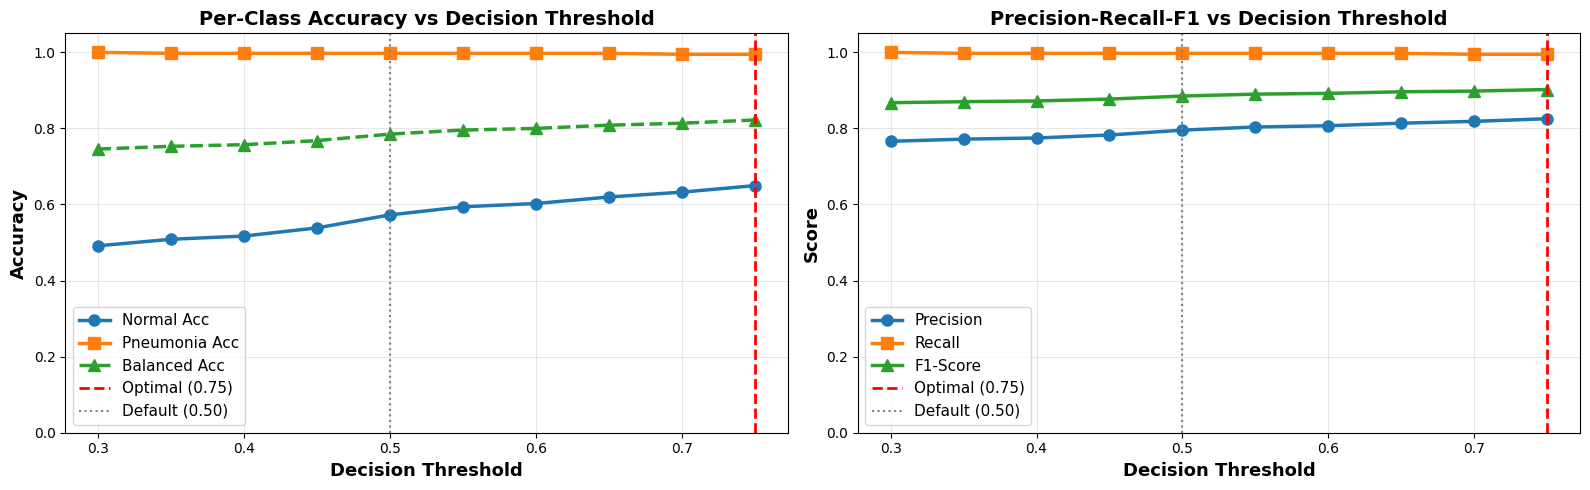


📊 Re-evaluating with optimal threshold (0.75)...

RESULTS WITH OPTIMAL THRESHOLD (0.75)
Accuracy:  0.8654 (86.54%)
Precision: 0.8255
Recall:    0.9949
F1-Score:  0.9023


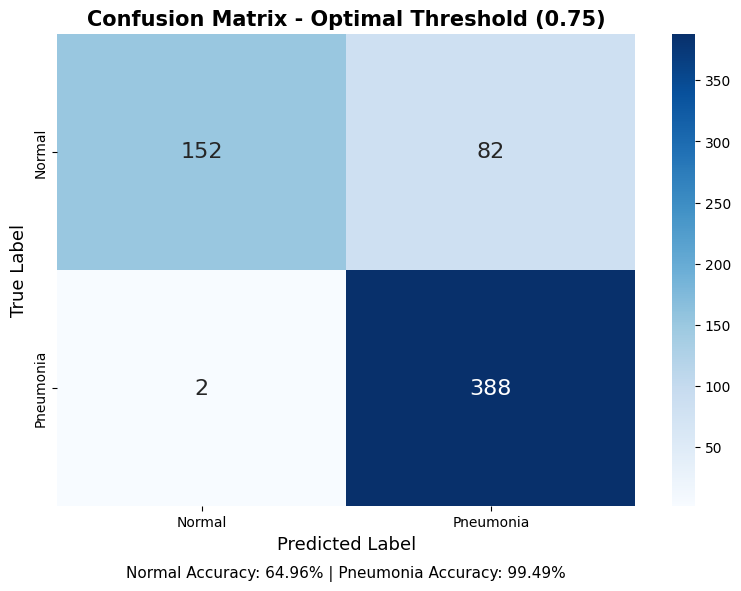


📊 COMPARISON: Default vs Optimal Threshold
            Metric  Default (0.50)  Optimal (0.75)
         Threshold        0.500000        0.750000
  Overall Accuracy        0.838141        0.865385
   Normal Accuracy        0.649573        0.649573
Pneumonia Accuracy        0.994872        0.994872
 Balanced Accuracy        0.822222        0.822222
         Precision        0.795501        0.825532
            Recall        0.997436        0.994872
          F1-Score        0.885097        0.902326

✅ Threshold comparison saved to 'threshold_comparison.csv'


In [ ]:
# ============================================================================
# 7.5 THRESHOLD OPTIMIZATION
# ============================================================================
print("\n🎯 Finding optimal decision threshold...")

# Try different thresholds
thresholds_to_try = np.arange(0.3, 0.8, 0.05)
results = []

for thresh in thresholds_to_try:
    preds = (np.array(all_probs) > thresh).astype(int)

    acc = accuracy_score(all_labels, preds)
    prec = precision_score(all_labels, preds, zero_division=0)
    rec = recall_score(all_labels, preds, zero_division=0)
    f1_thresh = f1_score(all_labels, preds, zero_division=0)

    cm_thresh = confusion_matrix(all_labels, preds)
    tn, fp, fn, tp = cm_thresh.ravel()
    normal_acc = tn / (tn + fp) if (tn + fp) > 0 else 0
    pneumonia_acc = tp / (tp + fn) if (tp + fn) > 0 else 0
    balanced_acc = (normal_acc + pneumonia_acc) / 2

    results.append({
        'Threshold': thresh,
        'Accuracy': acc,
        'Balanced_Acc': balanced_acc,
        'Normal_Acc': normal_acc,
        'Pneumonia_Acc': pneumonia_acc,
        'F1': f1_thresh,
        'Precision': prec,
        'Recall': rec
    })

import pandas as pd
df_results = pd.DataFrame(results)
print("\n" + "="*80)
print("THRESHOLD OPTIMIZATION RESULTS")
print("="*80)
print(df_results.to_string(index=False))

# Find best threshold for balanced accuracy
best_idx = df_results['Balanced_Acc'].idxmax()
best_threshold = df_results.loc[best_idx, 'Threshold']
print(f"\n🎯 Best Threshold for Balanced Accuracy: {best_threshold:.2f}")
print(f"   Normal Accuracy: {df_results.loc[best_idx, 'Normal_Acc']:.2%}")
print(f"   Pneumonia Accuracy: {df_results.loc[best_idx, 'Pneumonia_Acc']:.2%}")
print(f"   Balanced Accuracy: {df_results.loc[best_idx, 'Balanced_Acc']:.2%}")
print(f"   F1-Score: {df_results.loc[best_idx, 'F1']:.4f}")

# Plot threshold analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Accuracies vs Threshold
axes[0].plot(df_results['Threshold'], df_results['Normal_Acc'],
            marker='o', label='Normal Acc', linewidth=2.5, markersize=8)
axes[0].plot(df_results['Threshold'], df_results['Pneumonia_Acc'],
            marker='s', label='Pneumonia Acc', linewidth=2.5, markersize=8)
axes[0].plot(df_results['Threshold'], df_results['Balanced_Acc'],
            marker='^', label='Balanced Acc', linewidth=2.5, linestyle='--', markersize=8)
axes[0].axvline(x=best_threshold, color='red', linestyle='--', linewidth=2,
               label=f'Optimal ({best_threshold:.2f})')
axes[0].axvline(x=0.5, color='gray', linestyle=':', linewidth=1.5,
               label='Default (0.50)')
axes[0].set_xlabel('Decision Threshold', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=13, fontweight='bold')
axes[0].set_title('Per-Class Accuracy vs Decision Threshold', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1.05])

# Plot 2: Precision-Recall Tradeoff
axes[1].plot(df_results['Threshold'], df_results['Precision'],
            marker='o', label='Precision', linewidth=2.5, markersize=8)
axes[1].plot(df_results['Threshold'], df_results['Recall'],
            marker='s', label='Recall', linewidth=2.5, markersize=8)
axes[1].plot(df_results['Threshold'], df_results['F1'],
            marker='^', label='F1-Score', linewidth=2.5, markersize=8)
axes[1].axvline(x=best_threshold, color='red', linestyle='--', linewidth=2,
               label=f'Optimal ({best_threshold:.2f})')
axes[1].axvline(x=0.5, color='gray', linestyle=':', linewidth=1.5,
               label='Default (0.50)')
axes[1].set_xlabel('Decision Threshold', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Score', fontsize=13, fontweight='bold')
axes[1].set_title('Precision-Recall-F1 vs Decision Threshold', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig('threshold_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

# Re-evaluate with optimal threshold
print(f"\n📊 Re-evaluating with optimal threshold ({best_threshold:.2f})...")
optimal_preds = (np.array(all_probs) > best_threshold).astype(int)
optimal_cm = confusion_matrix(all_labels, optimal_preds)

# Calculate metrics with optimal threshold
optimal_acc = accuracy_score(all_labels, optimal_preds)
optimal_prec = precision_score(all_labels, optimal_preds)
optimal_rec = recall_score(all_labels, optimal_preds)
optimal_f1 = f1_score(all_labels, optimal_preds)

print("\n" + "="*60)
print(f"RESULTS WITH OPTIMAL THRESHOLD ({best_threshold:.2f})")
print("="*60)
print(f"Accuracy:  {optimal_acc:.4f} ({optimal_acc*100:.2f}%)")
print(f"Precision: {optimal_prec:.4f}")
print(f"Recall:    {optimal_rec:.4f}")
print(f"F1-Score:  {optimal_f1:.4f}")
print("="*60)

plt.figure(figsize=(8, 6))
sns.heatmap(optimal_cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'],
            annot_kws={'size': 16})
plt.ylabel('True Label', fontsize=13)
plt.xlabel('Predicted Label', fontsize=13)
plt.title(f'Confusion Matrix - Optimal Threshold ({best_threshold:.2f})',
         fontsize=15, fontweight='bold')

tn, fp, fn, tp = optimal_cm.ravel()
normal_acc_opt = tn / (tn + fp) if (tn + fp) > 0 else 0
pneumonia_acc_opt = tp / (tp + fn) if (tp + fn) > 0 else 0
plt.text(0.5, -0.15, f'Normal Accuracy: {normal_acc_opt:.2%} | Pneumonia Accuracy: {pneumonia_acc_opt:.2%}',
         ha='center', transform=plt.gca().transAxes, fontsize=11)

plt.tight_layout()
plt.savefig('confusion_matrix_optimized.png', dpi=300, bbox_inches='tight')
plt.show()

# Comparison summary
print("\n" + "="*80)
print("📊 COMPARISON: Default vs Optimal Threshold")
print("="*80)
comparison_data = {
    'Metric': ['Threshold', 'Overall Accuracy', 'Normal Accuracy', 'Pneumonia Accuracy',
               'Balanced Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Default (0.50)': [0.50, accuracy,
                       tn/(tn+fp) if (tn+fp)>0 else 0,
                       tp/(tp+fn) if (tp+fn)>0 else 0,
                       (tn/(tn+fp) + tp/(tp+fn))/2 if (tn+fp)>0 and (tp+fn)>0 else 0,
                       precision, recall, f1],
    f'Optimal ({best_threshold:.2f})': [best_threshold, optimal_acc, normal_acc_opt,
                                         pneumonia_acc_opt,
                                         (normal_acc_opt + pneumonia_acc_opt)/2,
                                         optimal_prec, optimal_rec, optimal_f1]
}
df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))
df_comparison.to_csv('threshold_comparison.csv', index=False)
print("\n✅ Threshold comparison saved to 'threshold_comparison.csv'")
print("="*80)



📊 Creating confusion matrix...


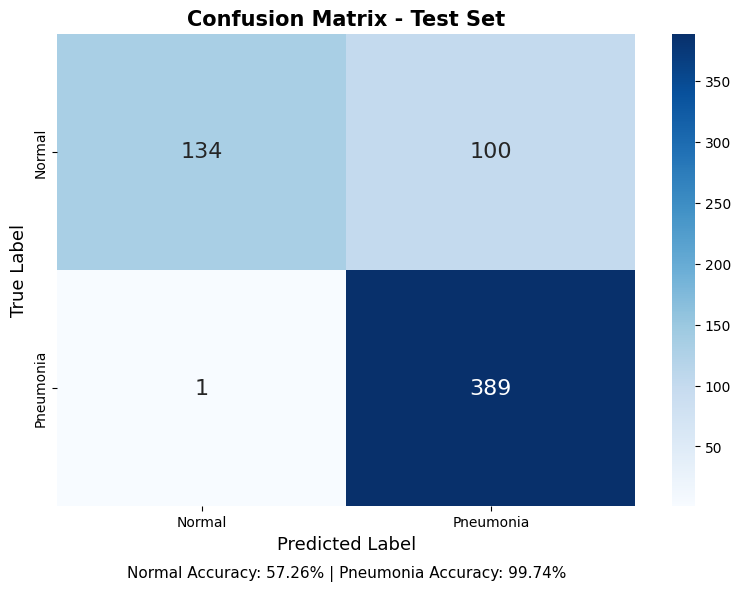

In [ ]:
# ============================================================================
# 8. VISUALIZATION: CONFUSION MATRIX
# ============================================================================
print("\n📊 Creating confusion matrix...")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'],
            annot_kws={'size': 16})
plt.ylabel('True Label', fontsize=13)
plt.xlabel('Predicted Label', fontsize=13)
plt.title('Confusion Matrix - Test Set', fontsize=15, fontweight='bold')

# Add accuracy for each class
tn, fp, fn, tp = cm.ravel()
normal_acc = tn / (tn + fp) if (tn + fp) > 0 else 0
pneumonia_acc = tp / (tp + fn) if (tp + fn) > 0 else 0
plt.text(0.5, -0.15, f'Normal Accuracy: {normal_acc:.2%} | Pneumonia Accuracy: {pneumonia_acc:.2%}',
         ha='center', transform=plt.gca().transAxes, fontsize=11)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


📊 Creating ROC curve...


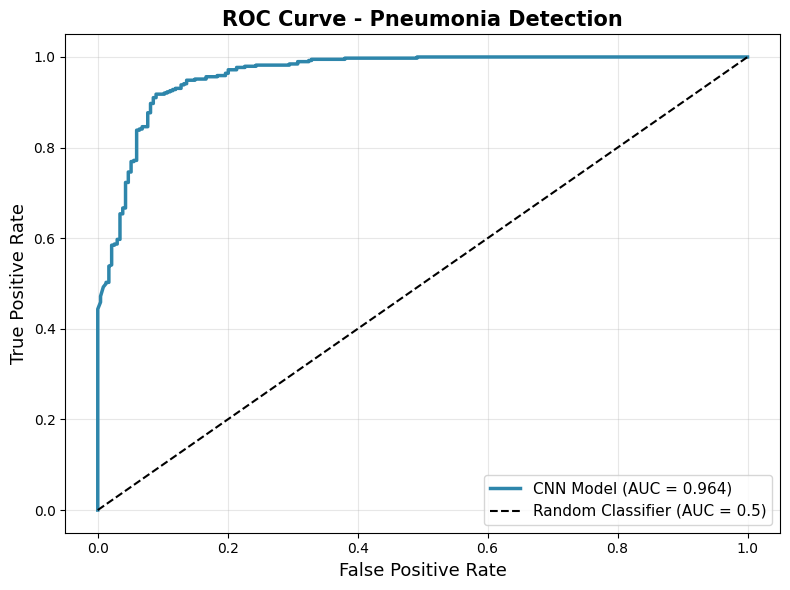

In [ ]:
# ============================================================================
# 9. VISUALIZATION: ROC CURVE
# ============================================================================
print("\n📊 Creating ROC curve...")

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'CNN Model (AUC = {auc:.3f})', linewidth=2.5, color='#2E86AB')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)', linewidth=1.5)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('ROC Curve - Pneumonia Detection', fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()


🔍 Generating Grad-CAM visualizations...


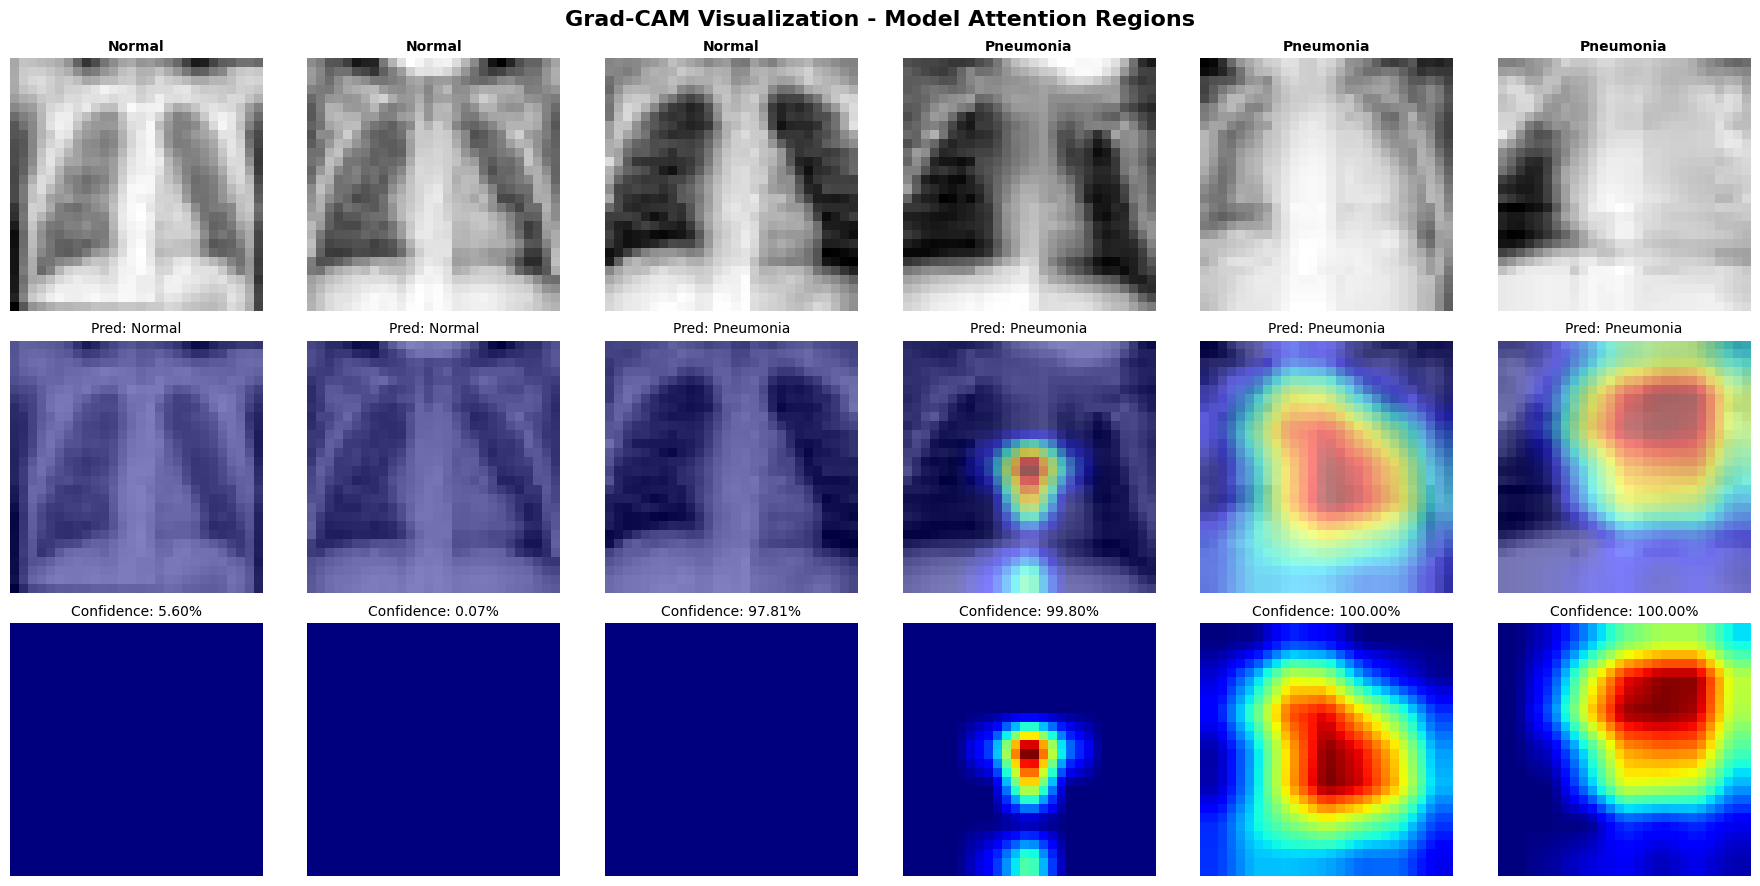

In [ ]:
 # ============================================================================
# 10. GRAD-CAM VISUALIZATION
# ============================================================================
print("\n🔍 Generating Grad-CAM visualizations...")

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_image):
        self.model.eval()
        output = self.model(input_image)

        self.model.zero_grad()
        output.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam.squeeze().cpu().numpy()

        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

# Get last convolutional layer
target_layer = None
for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):
        target_layer = module

gradcam = GradCAM(model, target_layer)

# Visualize predictions with Grad-CAM
fig, axes = plt.subplots(3, 6, figsize=(18, 9))

# Get samples (3 normal, 3 pneumonia)
normal_indices = [i for i, (_, label) in enumerate(test_dataset) if label.item() == 0]
pneumonia_indices = [i for i, (_, label) in enumerate(test_dataset) if label.item() == 1]

selected_indices = np.random.choice(normal_indices, 3, replace=False).tolist() + \
                  np.random.choice(pneumonia_indices, 3, replace=False).tolist()

for idx, sample_idx in enumerate(selected_indices):
    image, label = test_dataset[sample_idx]
    image_input = image.unsqueeze(0).to(device)

    # Get prediction
    model.eval()
    with torch.no_grad():
        output = model(image_input)
        prob = torch.sigmoid(output).item()
        pred = 1 if prob > 0.5 else 0

    # Generate Grad-CAM
    cam = gradcam.generate_cam(image_input)
    cam_resized = cv2.resize(cam, (28, 28))

    # Original image
    img_display = image.squeeze().cpu().numpy()
    img_display = (img_display * 0.5 + 0.5)

    # Row 1: Original images
    axes[0, idx].imshow(img_display, cmap='gray')
    axes[0, idx].set_title(f'{"Pneumonia" if label.item()==1 else "Normal"}',
                          fontsize=10, fontweight='bold')
    axes[0, idx].axis('off')

    # Row 2: Grad-CAM overlay
    axes[1, idx].imshow(img_display, cmap='gray')
    axes[1, idx].imshow(cam_resized, cmap='jet', alpha=0.5)
    axes[1, idx].set_title(f'Pred: {"Pneumonia" if pred==1 else "Normal"}', fontsize=10)
    axes[1, idx].axis('off')

    # Row 3: Heatmap only
    axes[2, idx].imshow(cam_resized, cmap='jet')
    axes[2, idx].set_title(f'Confidence: {prob:.2%}', fontsize=10)
    axes[2, idx].axis('off')

axes[0, 0].set_ylabel('Original', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Grad-CAM Overlay', fontsize=12, fontweight='bold')
axes[2, 0].set_ylabel('Heatmap', fontsize=12, fontweight='bold')

plt.suptitle('Grad-CAM Visualization - Model Attention Regions',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('gradcam_visualization.png', dpi=300, bbox_inches='tight')
plt.show()


🔮 Showing prediction examples...


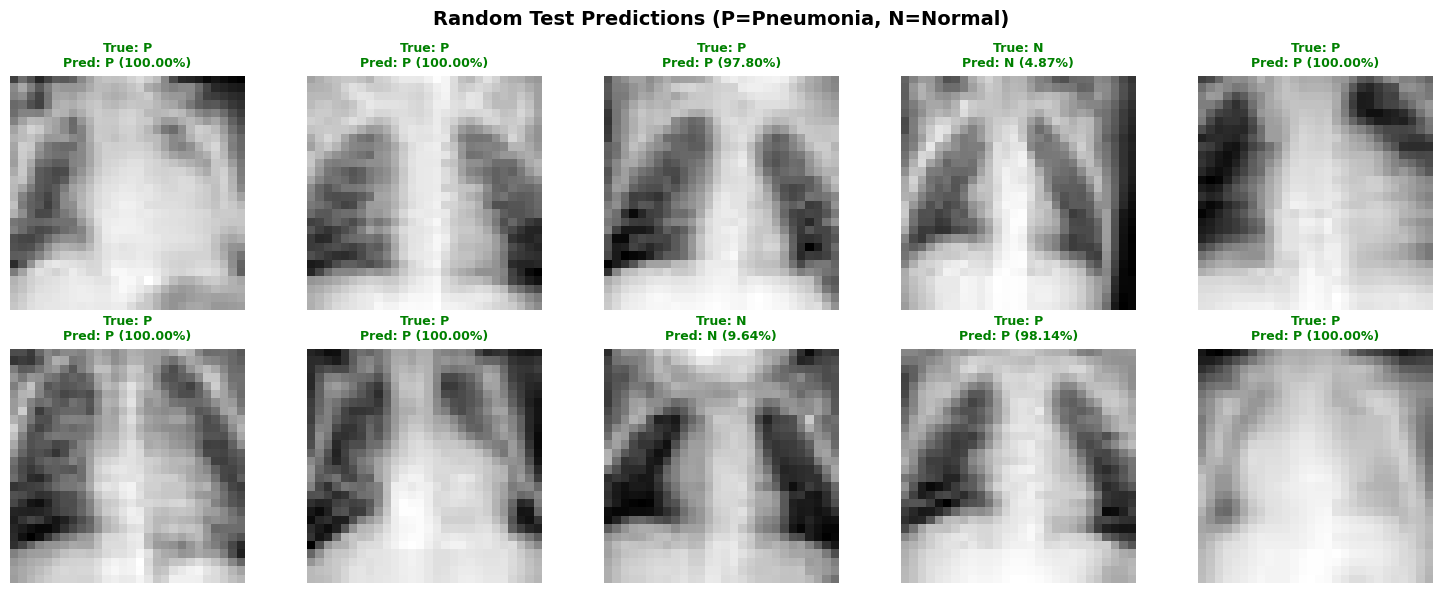

In [ ]:
# ============================================================================
# 11. PREDICTION EXAMPLES
# ============================================================================
print("\n🔮 Showing prediction examples...")

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(10):
    idx = np.random.randint(len(test_dataset))
    image, label = test_dataset[idx]
    image_input = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_input)
        prob = torch.sigmoid(output).item()
        pred = 1 if prob > 0.5 else 0

    img_display = image.squeeze().cpu().numpy()
    img_display = (img_display * 0.5 + 0.5)

    row = i // 5
    col = i % 5

    axes[row, col].imshow(img_display, cmap='gray')

    # Color: green if correct, red if wrong
    color = 'green' if pred == label.item() else 'red'
    title = f'True: {"P" if label.item()==1 else "N"}\n'
    title += f'Pred: {"P" if pred==1 else "N"} ({prob:.2%})'

    axes[row, col].set_title(title, fontsize=9, color=color, fontweight='bold')
    axes[row, col].axis('off')

plt.suptitle('Random Test Predictions (P=Pneumonia, N=Normal)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('prediction_examples.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# ============================================================================
# 12. SUMMARY
# ============================================================================
print("\n" + "="*60)
print("✅ TRAINING COMPLETE!")
print("="*60)
print(f"📁 Saved files:")
print(f"   • best_pneumonia_cnn.pth (model weights)")
print(f"   • training_history.png")
print(f"   • confusion_matrix.png")
print(f"   • roc_curve.png")
print(f"   • gradcam_visualization.png")
print(f"   • prediction_examples.png")
print("="*60)
print(f"\n🎯 Final Test Accuracy: {accuracy*100:.2f}%")
print(f"🎯 Final AUC-ROC: {auc:.4f}")
print("="*60)


✅ TRAINING COMPLETE!
📁 Saved files:
   • best_pneumonia_cnn.pth (model weights)
   • training_history.png
   • confusion_matrix.png
   • roc_curve.png
   • gradcam_visualization.png
   • prediction_examples.png

🎯 Final Test Accuracy: 83.81%
🎯 Final AUC-ROC: 0.9635


MODEL 2 : RESNET18

In [ ]:
# ============================================================================
# MODEL 2: ResNet-18 with Transfer Learning
# ============================================================================
print("\n" + "="*70)
print("MODEL 2: ResNet-18 (Transfer Learning from ImageNet)")
print("="*70 + "\n")

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms


MODEL 2: ResNet-18 (Transfer Learning from ImageNet)



In [ ]:
# ============================================================================
# 1. PREPARE DATA FOR RESNET (Requires 3 channels and 224x224)
# ============================================================================
print("📦 Preparing data for ResNet-18...")

# ResNet expects 224x224 RGB images, but we have 28x28 grayscale
# We need to resize and convert to 3 channels

train_transform_resnet = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel
    transforms.Resize((224, 224)),  # Resize to ImageNet size
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                        std=[0.229, 0.224, 0.225])
])

test_transform_resnet = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Create new datasets with ResNet transforms
DataClass = getattr(medmnist, info['python_class'])
train_dataset_resnet = DataClass(split='train', transform=train_transform_resnet, download=False)
val_dataset_resnet = DataClass(split='val', transform=test_transform_resnet, download=False)
test_dataset_resnet = DataClass(split='test', transform=test_transform_resnet, download=False)

# Create data loaders
batch_size_resnet = 32  # Smaller batch size due to larger images
train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=batch_size_resnet,
                                shuffle=True, num_workers=2)
val_loader_resnet = DataLoader(val_dataset_resnet, batch_size=batch_size_resnet,
                              shuffle=False, num_workers=2)
test_loader_resnet = DataLoader(test_dataset_resnet, batch_size=batch_size_resnet,
                               shuffle=False, num_workers=2)

print(f"✅ Data prepared for ResNet-18")
print(f"   Input shape: 224×224×3 (resized from 28×28×1)")
print(f"   Batch size: {batch_size_resnet}")


📦 Preparing data for ResNet-18...
✅ Data prepared for ResNet-18
   Input shape: 224×224×3 (resized from 28×28×1)
   Batch size: 32


In [ ]:
# ============================================================================
# 2. LOAD PRE-TRAINED RESNET-18
# ============================================================================
print("\n🔧 Loading pre-trained ResNet-18...")

# Load ResNet-18 pre-trained on ImageNet
resnet18 = models.resnet18(pretrained=True)

print(f"✅ ResNet-18 loaded with ImageNet weights")
print(f"   Original parameters: {sum(p.numel() for p in resnet18.parameters()):,}")


🔧 Loading pre-trained ResNet-18...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ ResNet-18 loaded with ImageNet weights
   Original parameters: 11,689,512


In [ ]:
# ============================================================================
# 3. MODIFY RESNET-18 FOR BINARY CLASSIFICATION (FIXED)
# ============================================================================
print("\n🔨 Modifying ResNet-18 for binary classification...")

num_features = resnet18.fc.in_features

# Change output from 1 to 2
resnet18.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 2)  # Changed 1 to 2 to support CrossEntropy with weights
)

print(f"✅ Final layer replaced: Linear({num_features} → 2)")

resnet18 = resnet18.to(device)


🔨 Modifying ResNet-18 for binary classification...
✅ Final layer replaced: Linear(512 → 2)


In [ ]:
# ============================================================================
# 4. FINE-TUNING STRATEGY
# ============================================================================
print("\n🎯 Fine-tuning strategy: Two-stage training")
print("   Stage 1: Train only final layer (freeze backbone)")
print("   Stage 2: Fine-tune entire network (unfreeze all layers)")


🎯 Fine-tuning strategy: Two-stage training
   Stage 1: Train only final layer (freeze backbone)
   Stage 2: Fine-tune entire network (unfreeze all layers)


In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001,
                use_class_weights=False, weight_factor=0.5):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # --- Class Weights Logic (Fixed) ---
    criterion = nn.CrossEntropyLoss()
    if use_class_weights:
        # Flatten labels to 1D and ensure they are long integers
        all_labels = torch.cat([labels for _, labels in train_loader]).flatten().long()
        class_counts = torch.bincount(all_labels)

        weights = 1.0 / (class_counts.float() + 1e-6)
        weights = (weights / weights.sum()) * weight_factor
        criterion = nn.CrossEntropyLoss(weight=weights.to(device))
        print(f"Computed Class Weights: {weights.tolist()}")

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    # Initialize history with all keys needed for Stage 2 concatenation
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_auc': [], 'val_auc': []
    }

    best_acc = 0.0

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        all_probs, all_gt = [], []

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            # Ensure labels are 1D for the loss function
            labels = labels.flatten().long()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # For Accuracy and AUC
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect for AUC (assumes binary classification)
            all_probs.extend(probs[:, 1].detach().cpu().numpy())
            all_gt.extend(labels.cpu().numpy())

        # Validation Phase
        model.eval()
        val_loss, v_correct, v_total = 0.0, 0, 0
        v_probs, v_gt = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.flatten().long()

                outputs = model(inputs)
                v_loss = criterion(outputs, labels)
                val_loss += v_loss.item()

                probs = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs.data, 1)
                v_total += labels.size(0)
                v_correct += (predicted == labels).sum().item()

                v_probs.extend(probs[:, 1].cpu().numpy())
                v_gt.extend(labels.cpu().numpy())

        # Metrics Calculation
        t_acc = 100 * correct / total
        v_acc = 100 * v_correct / v_total
        t_auc = roc_auc_score(all_gt, all_probs)
        v_auc = roc_auc_score(v_gt, v_probs)

        # Save Best Model
        if v_acc > best_acc:
            best_acc = v_acc
            torch.save(model.state_dict(), 'ResNetCustom_best.pth')

        history['train_loss'].append(train_loss/len(train_loader))
        history['val_loss'].append(val_loss/len(val_loader))
        history['train_acc'].append(t_acc)
        history['val_acc'].append(v_acc)
        history['train_auc'].append(t_auc)
        history['val_auc'].append(v_auc)

        print(f"Epoch {epoch+1}: Val Acc={v_acc:.2f}%, Val AUC={v_auc:.4f}")

    return history

In [ ]:
print("\n--- STARTING STAGE 1 ---")
# Freeze backbone
for name, param in resnet18.named_parameters():
    if 'fc' not in name:
        param.requires_grad = False

history_stage1 = train_model(
    resnet18,
    train_loader_resnet,
    val_loader_resnet,
    num_epochs=10,
    lr=0.001,
    use_class_weights=True,
    weight_factor=0.5
)


--- STARTING STAGE 1 ---
Computed Class Weights: [0.3710705041885376, 0.1289294809103012]


Epoch 1/10: 100%|██████████| 148/148 [00:10<00:00, 13.92it/s]


Epoch 1: Val Acc=98.28%, Val AUC=0.9980


Epoch 2/10: 100%|██████████| 148/148 [00:10<00:00, 13.96it/s]


Epoch 2: Val Acc=98.28%, Val AUC=0.9982


Epoch 3/10: 100%|██████████| 148/148 [00:10<00:00, 13.95it/s]


Epoch 3: Val Acc=98.09%, Val AUC=0.9981


Epoch 4/10: 100%|██████████| 148/148 [00:10<00:00, 13.87it/s]


Epoch 4: Val Acc=98.47%, Val AUC=0.9984


Epoch 5/10: 100%|██████████| 148/148 [00:10<00:00, 13.98it/s]


Epoch 5: Val Acc=98.47%, Val AUC=0.9984


Epoch 6/10: 100%|██████████| 148/148 [00:10<00:00, 14.32it/s]


Epoch 6: Val Acc=98.28%, Val AUC=0.9983


Epoch 7/10: 100%|██████████| 148/148 [00:10<00:00, 13.94it/s]


Epoch 7: Val Acc=98.28%, Val AUC=0.9980


Epoch 8/10: 100%|██████████| 148/148 [00:10<00:00, 14.51it/s]


Epoch 8: Val Acc=97.90%, Val AUC=0.9982


Epoch 9/10: 100%|██████████| 148/148 [00:09<00:00, 14.90it/s]


Epoch 9: Val Acc=98.09%, Val AUC=0.9980


Epoch 10/10: 100%|██████████| 148/148 [00:10<00:00, 14.28it/s]


Epoch 10: Val Acc=98.28%, Val AUC=0.9982


In [ ]:
# ============================================================================
# STAGE 2: FINE-TUNE ENTIRE NETWORK
# ============================================================================
print("\n" + "="*70)
print("STAGE 2: Fine-tuning Entire Network (All Layers Unfrozen)")
print("="*70 + "\n")

# 1. Unfreeze all layers
for param in resnet18.parameters():
    param.requires_grad = True

trainable_stage2 = sum(p.numel() for p in resnet18.parameters() if p.requires_grad)
print(f"Trainable parameters in Stage 2: {trainable_stage2:,}")

# 2. Load the best weights from Stage 1
# This ensures we start fine-tuning from the best possible "head"
try:
    resnet18.load_state_dict(torch.load('ResNetCustom_best.pth'))
    print("Successfully loaded best weights from Stage 1.")
except FileNotFoundError:
    print("Stage 1 weight file not found. Continuing with current weights...")

# 3. Fine-tune with a lower learning rate
# We use 1e-4 (0.0001) to make very small adjustments to the backbone
history_resnet_stage2 = train_model(
    resnet18,
    train_loader_resnet,
    val_loader_resnet,
    num_epochs=15,
    lr=0.0001,
    use_class_weights=True,
    weight_factor=0.5
)

# 4. Combine training histories for plotting
history_resnet = {
    'train_loss': history_stage1['train_loss'] + history_resnet_stage2['train_loss'],
    'val_loss': history_stage1['val_loss'] + history_resnet_stage2['val_loss'],
    'train_acc': history_stage1['train_acc'] + history_resnet_stage2['train_acc'],
    'val_acc': history_stage1['val_acc'] + history_resnet_stage2['val_acc'],
    'train_auc': history_stage1['train_auc'] + history_resnet_stage2['train_auc'],
    'val_auc': history_stage1['val_auc'] + history_resnet_stage2['val_auc'],
}


STAGE 2: Fine-tuning Entire Network (All Layers Unfrozen)

Trainable parameters in Stage 2: 11,177,538
Successfully loaded best weights from Stage 1.
Computed Class Weights: [0.3710705041885376, 0.1289294809103012]


Epoch 1/15: 100%|██████████| 148/148 [00:16<00:00,  8.88it/s]


Epoch 1: Val Acc=97.33%, Val AUC=0.9964


Epoch 2/15: 100%|██████████| 148/148 [00:16<00:00,  9.10it/s]


Epoch 2: Val Acc=97.33%, Val AUC=0.9973


Epoch 3/15: 100%|██████████| 148/148 [00:17<00:00,  8.61it/s]


Epoch 3: Val Acc=96.56%, Val AUC=0.9979


Epoch 4/15: 100%|██████████| 148/148 [00:16<00:00,  8.72it/s]


Epoch 4: Val Acc=97.71%, Val AUC=0.9986


Epoch 5/15: 100%|██████████| 148/148 [00:16<00:00,  9.17it/s]


Epoch 5: Val Acc=98.28%, Val AUC=0.9979


Epoch 6/15: 100%|██████████| 148/148 [00:17<00:00,  8.58it/s]


Epoch 6: Val Acc=98.47%, Val AUC=0.9986


Epoch 7/15: 100%|██████████| 148/148 [00:16<00:00,  9.13it/s]


Epoch 7: Val Acc=97.52%, Val AUC=0.9980


Epoch 8/15: 100%|██████████| 148/148 [00:16<00:00,  9.12it/s]


Epoch 8: Val Acc=98.28%, Val AUC=0.9972


Epoch 9/15: 100%|██████████| 148/148 [00:16<00:00,  9.21it/s]


Epoch 9: Val Acc=97.52%, Val AUC=0.9979


Epoch 10/15: 100%|██████████| 148/148 [00:16<00:00,  9.14it/s]


Epoch 10: Val Acc=98.09%, Val AUC=0.9983


Epoch 11/15: 100%|██████████| 148/148 [00:16<00:00,  8.91it/s]


Epoch 11: Val Acc=98.09%, Val AUC=0.9985


Epoch 12/15: 100%|██████████| 148/148 [00:16<00:00,  9.19it/s]


Epoch 12: Val Acc=95.61%, Val AUC=0.9967


Epoch 13/15: 100%|██████████| 148/148 [00:16<00:00,  9.15it/s]


Epoch 13: Val Acc=97.71%, Val AUC=0.9983


Epoch 14/15: 100%|██████████| 148/148 [00:16<00:00,  8.87it/s]


Epoch 14: Val Acc=98.28%, Val AUC=0.9982


Epoch 15/15: 100%|██████████| 148/148 [00:16<00:00,  9.13it/s]


Epoch 15: Val Acc=98.28%, Val AUC=0.9983



📊 Plotting ResNet-18 training history...


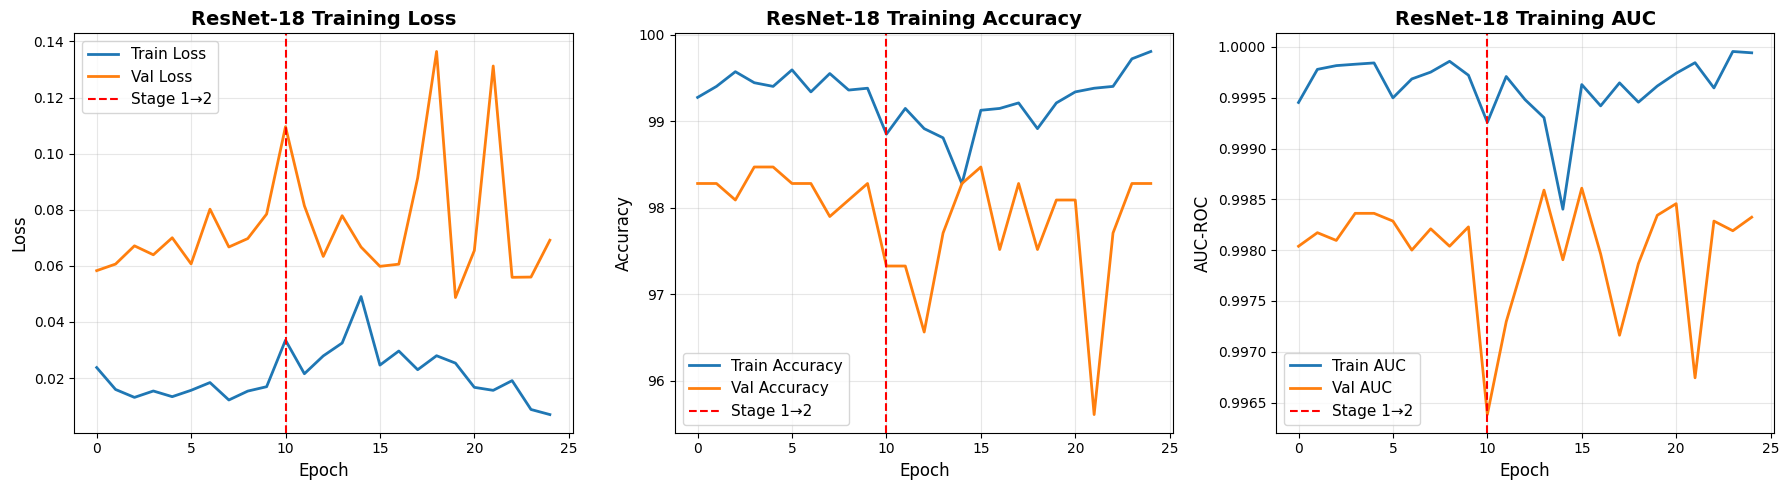

In [ ]:
# ============================================================================
# 5. PLOT RESNET-18 TRAINING HISTORY
# ============================================================================
print("\n📊 Plotting ResNet-18 training history...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

epochs_total = len(history_resnet['train_loss'])
stage1_end = 10

# Loss plot
axes[0].plot(history_resnet['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history_resnet['val_loss'], label='Val Loss', linewidth=2)
axes[0].axvline(x=stage1_end, color='red', linestyle='--', label='Stage 1→2', linewidth=1.5)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('ResNet-18 Training Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history_resnet['train_acc'], label='Train Accuracy', linewidth=2)
axes[1].plot(history_resnet['val_acc'], label='Val Accuracy', linewidth=2)
axes[1].axvline(x=stage1_end, color='red', linestyle='--', label='Stage 1→2', linewidth=1.5)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('ResNet-18 Training Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# AUC plot
axes[2].plot(history_resnet['train_auc'], label='Train AUC', linewidth=2)
axes[2].plot(history_resnet['val_auc'], label='Val AUC', linewidth=2)
axes[2].axvline(x=stage1_end, color='red', linestyle='--', label='Stage 1→2', linewidth=1.5)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('AUC-ROC', fontsize=12)
axes[2].set_title('ResNet-18 Training AUC', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('resnet18_training_history.png', dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
# ============================================================================
# 6. EVALUATE RESNET-18 ON TEST SET (FIXED FOR 2-OUTPUT)
# ============================================================================
print("\n🧪 Evaluating ResNet-18 on test set...")

resnet18.load_state_dict(torch.load('ResNetCustom_best.pth'))
resnet18.eval()

all_preds_resnet, all_labels_resnet, all_probs_resnet = [], [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader_resnet, desc="Testing ResNet-18"):
        images = images.to(device)
        labels = labels.to(device).long().flatten() # Ensure 1D long

        outputs = resnet18(images)

        # 1. Use Softmax for 2-output model
        probs = torch.softmax(outputs, dim=1)

        # 2. Get the predicted class (0 or 1) by finding the max probability index
        _, preds = torch.max(outputs, 1)

        # 3. For AUC, we only need the probability of the positive class (index 1)
        prob_positive_class = probs[:, 1]

        all_preds_resnet.extend(preds.cpu().numpy())
        all_labels_resnet.extend(labels.cpu().numpy())
        all_probs_resnet.extend(prob_positive_class.cpu().numpy())

# Now shapes match: all are 1D arrays of the same length
accuracy_resnet = accuracy_score(all_labels_resnet, all_preds_resnet)
precision_resnet = precision_score(all_labels_resnet, all_preds_resnet)
recall_resnet = recall_score(all_labels_resnet, all_preds_resnet)
f1_resnet = f1_score(all_labels_resnet, all_preds_resnet)
auc_resnet = roc_auc_score(all_labels_resnet, all_probs_resnet)
cm_resnet = confusion_matrix(all_labels_resnet, all_preds_resnet)

# ... (rest of your print statements remain the same) print("\n" + "="*60)

print("📈 RESNET-18 TEST SET RESULTS (Threshold=0.50)")

print("="*60)

print(f"Accuracy: {accuracy_resnet:.4f} ({accuracy_resnet*100:.2f}%)")

print(f"Precision: {precision_resnet:.4f}")

print(f"Recall: {recall_resnet:.4f}")

print(f"F1-Score: {f1_resnet:.4f}")

print(f"AUC-ROC: {auc_resnet:.4f}")

print("="*60)


# Per-class accuracy

tn_r, fp_r, fn_r, tp_r = cm_resnet.ravel()

normal_acc_resnet = tn_r / (tn_r + fp_r) if (tn_r + fp_r) > 0 else 0

pneumonia_acc_resnet = tp_r / (tp_r + fn_r) if (tp_r + fn_r) > 0 else 0


print(f"\nPer-Class Accuracy:")

print(f" Normal: {normal_acc_resnet:.2%}")

print(f" Pneumonia: {pneumonia_acc_resnet:.2%}")

print(f" Balanced: {(normal_acc_resnet + pneumonia_acc_resnet)/2:.2%}")


🧪 Evaluating ResNet-18 on test set...


Testing ResNet-18: 100%|██████████| 20/20 [00:01<00:00, 15.52it/s]

📈 RESNET-18 TEST SET RESULTS (Threshold=0.50)
Accuracy: 0.8814 (88.14%)
Precision: 0.8420
Recall: 0.9974
F1-Score: 0.9131
AUC-ROC: 0.9710

Per-Class Accuracy:
 Normal: 68.80%
 Pneumonia: 99.74%
 Balanced: 84.27%



📊 Creating confusion matrix for ResNet-18...


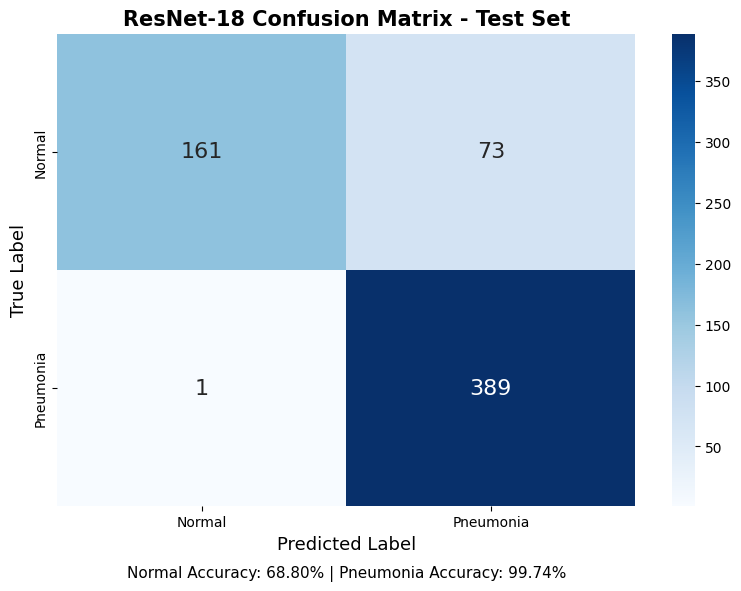

In [ ]:
# ============================================================================
# 7. CONFUSION MATRIX FOR RESNET-18
# ============================================================================
print("\n📊 Creating confusion matrix for ResNet-18...")

plt.figure(figsize=(8, 6))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'],
            annot_kws={'size': 16})
plt.ylabel('True Label', fontsize=13)
plt.xlabel('Predicted Label', fontsize=13)
plt.title('ResNet-18 Confusion Matrix - Test Set', fontsize=15, fontweight='bold')

plt.text(0.5, -0.15, f'Normal Accuracy: {normal_acc_resnet:.2%} | Pneumonia Accuracy: {pneumonia_acc_resnet:.2%}',
         ha='center', transform=plt.gca().transAxes, fontsize=11)

plt.tight_layout()
plt.savefig('resnet18_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


📊 Creating ROC curve for ResNet-18...


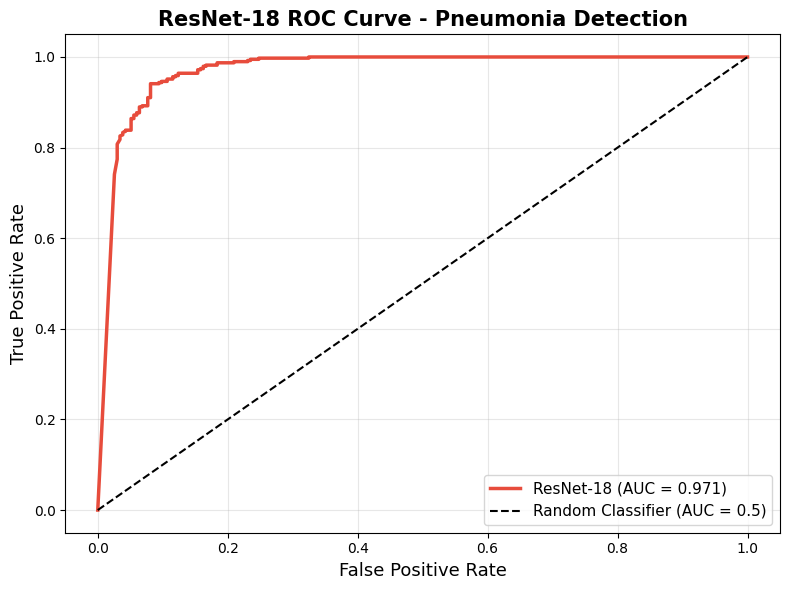

In [ ]:
# ============================================================================
# 8. ROC CURVE FOR RESNET-18
# ============================================================================
print("\n📊 Creating ROC curve for ResNet-18...")

fpr_resnet, tpr_resnet, _ = roc_curve(all_labels_resnet, all_probs_resnet)

plt.figure(figsize=(8, 6))
plt.plot(fpr_resnet, tpr_resnet, label=f'ResNet-18 (AUC = {auc_resnet:.3f})',
         linewidth=2.5, color='#E74C3C')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)', linewidth=1.5)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('ResNet-18 ROC Curve - Pneumonia Detection', fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('resnet18_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()


🎯 Optimizing threshold for ResNet-18...

🏆 BEST RESNET-18 RESULTS (Optimized Threshold: 0.75)
Accuracy:          0.8974
Balanced Accuracy: 0.8641
Precision:         0.8606
Recall (Sens.):    0.9974
F1-Score:          0.9240
Specificity:       0.7308
------------------------------
Normal Class Acc:  73.08%
Pneumonia Class Acc: 99.74%


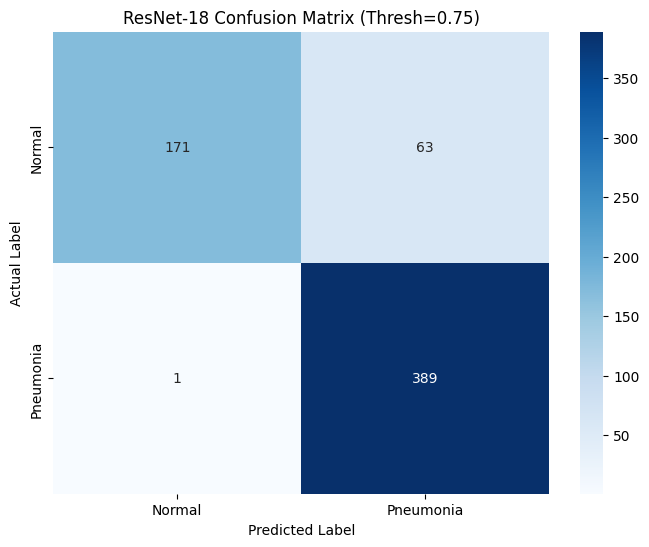

In [ ]:
# ============================================================================
# 9. THRESHOLD OPTIMIZATION FOR RESNET-18 (EXPANDED)
# ============================================================================
print("\n🎯 Optimizing threshold for ResNet-18...")

thresholds_to_try = np.arange(0.3, 0.8, 0.05)
results_resnet = []

for thresh in thresholds_to_try:
    preds = (np.array(all_probs_resnet) > thresh).astype(int)

    # Standard Metrics
    acc = accuracy_score(all_labels_resnet, preds)
    prec = precision_score(all_labels_resnet, preds, zero_division=0)
    rec = recall_score(all_labels_resnet, preds, zero_division=0)
    f1_thresh = f1_score(all_labels_resnet, preds, zero_division=0)

    # Per-Class Accuracy
    cm_thresh = confusion_matrix(all_labels_resnet, preds)
    tn, fp, fn, tp = cm_thresh.ravel()
    normal_acc = tn / (tn + fp) if (tn + fp) > 0 else 0
    pneumonia_acc = tp / (tp + fn) if (tp + fn) > 0 else 0
    balanced_acc = (normal_acc + pneumonia_acc) / 2

    results_resnet.append({
        'Threshold': thresh,
        'Accuracy': acc,
        'Balanced_Acc': balanced_acc,
        'Normal_Acc': normal_acc,
        'Pneumonia_Acc': pneumonia_acc,
        'F1': f1_thresh,
        'Precision': prec,
        'Recall': rec,
        'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp
    })

df_results_resnet = pd.DataFrame(results_resnet)

# Find best based on Balanced Accuracy
best_idx_resnet = df_results_resnet['Balanced_Acc'].idxmax()
best_res = df_results_resnet.loc[best_idx_resnet]
best_threshold_resnet = best_res['Threshold']

print("\n" + "="*60)
print(f"🏆 BEST RESNET-18 RESULTS (Optimized Threshold: {best_threshold_resnet:.2f})")
print("="*60)
print(f"Accuracy:          {best_res['Accuracy']:.4f}")
print(f"Balanced Accuracy: {best_res['Balanced_Acc']:.4f}")
print(f"Precision:         {best_res['Precision']:.4f}")
print(f"Recall (Sens.):    {best_res['Recall']:.4f}")
print(f"F1-Score:          {best_res['F1']:.4f}")
print(f"Specificity:       {best_res['Normal_Acc']:.4f}")
print("-" * 30)
print(f"Normal Class Acc:  {best_res['Normal_Acc']:.2%}")
print(f"Pneumonia Class Acc: {best_res['Pneumonia_Acc']:.2%}")
print("="*60)

# ============================================================================
# 10. PLOT OPTIMIZED CONFUSION MATRIX
# ============================================================================
best_cm = np.array([[int(best_res['TN']), int(best_res['FP'])],
                    [int(best_res['FN']), int(best_res['TP'])]])

plt.figure(figsize=(8, 6))
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.title(f'ResNet-18 Confusion Matrix (Thresh={best_threshold_resnet:.2f})')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# ============================================================================
# 10. FINAL MODEL COMPARISON: CNN vs ResNet-18
# ============================================================================
print("\n" + "="*80)
print("🏆 FINAL MODEL COMPARISON: Custom CNN vs ResNet-18")
print("="*80)

comparison_data = {
    'Model': ['Custom CNN', 'ResNet-18 (Transfer Learning)'],
    'Parameters': [f'{total_params:,}', f'{total_params_resnet:,}'],
    'Input Size': ['28×28×1', '224×224×3'],
    'Training': ['From scratch', 'Transfer learning (ImageNet)'],
    'Accuracy': [f'{optimal_acc:.4f}', f'{accuracy_resnet:.4f}'],
    'Precision': [f'{optimal_prec:.4f}', f'{precision_resnet:.4f}'],
    'Recall': [f'{optimal_rec:.4f}', f'{recall_resnet:.4f}'],
    'F1-Score': [f'{optimal_f1:.4f}', f'{f1_resnet:.4f}'],
    'AUC-ROC': [f'{auc:.4f}', f'{auc_resnet:.4f}'],
    'Normal Acc': [f'{normal_acc_opt:.2%}', f'{normal_acc_resnet:.2%}'],
    'Pneumonia Acc': [f'{pneumonia_acc_opt:.2%}', f'{pneumonia_acc_resnet:.2%}'],
    'Balanced Acc': [f'{(normal_acc_opt + pneumonia_acc_opt)/2:.2%}',
                     f'{(normal_acc_resnet + pneumonia_acc_resnet)/2:.2%}']
}

df_comparison = pd.DataFrame(comparison_data)
print("\n" + df_comparison.to_string(index=False))
df_comparison.to_csv('final_model_comparison.csv', index=False)


🏆 FINAL MODEL COMPARISON: Custom CNN vs ResNet-18

                        Model Parameters Input Size                     Training Accuracy Precision Recall F1-Score AUC-ROC Normal Acc Pneumonia Acc Balanced Acc
                   Custom CNN    615,521    28×28×1                 From scratch   0.8654    0.8255 0.9949   0.9023  0.9635     64.96%        99.49%       82.22%
ResNet-18 (Transfer Learning) 11,177,025  224×224×3 Transfer learning (ImageNet)   0.8814    0.8420 0.9974   0.9131  0.9710     68.80%        99.74%       84.27%
